In [1]:
import networkx as nx
import numpy as np
import collections
import matplotlib.pyplot as plt

In [12]:
def graph_info(G):
    
    #degree distribution
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())
    fig, ax = plt.subplots()
    plt.bar(deg, cnt, width=0.80, color='salmon')
    plt.title("Распределбата на степени - " + str(G.name),fontsize=12)

    #clustering coefficient 
    print("Transitivity: " + str(nx.transitivity(G)))
    print("Average clustering coefficient: " + str(nx.average_clustering(G)))

    #average shortest path
    flag=True
    for cc in nx.connected_components(G):
        if flag:
            print("Average shortest path: " + str(nx.average_shortest_path_length(G.subgraph(cc))))
            flag=False
        
    plt.show()


In [3]:
def draw_edge_centralities(G,draw=True):
    """
    visualize the network with different color of edges (silver - low edge betweenness centrality;
                                                         black - high edge betweenness centrality)
    G -  a networkx graph
    draw - (boolean) ploting the graph
    """
    black_edges, edgelist = getHighCentralityEdges(G,hist=False)
    color_map = ["silver"] * len(edgelist)
    for edge in black_edges:
        color_map[edgelist.index(edge)]="black"
    
    matrix = nx.to_numpy_matrix(G)
    result = mc.run_mcl(matrix)          
    clusters = mc.get_clusters(result) 
    
    if draw:
        plt.figure(figsize=(7,7))
        plt.title("Edge Betweenness centrality - "+ G.name,fontsize=12)
        plt.axis('off')
        mc.draw_graph(matrix, clusters, pos=positions, node_size=50, with_labels=False, edgelist=list(edgelist), edge_color=list(color_map))
        plt.show()
    
    
    
def getHighCentralityEdges(G,hist=True):
    """
    return nodes with high edge betweenness centrality, edge-list of graph G
    
    G -  a networkx graph
    hist - (boolean) ploting the histogram of edge centrality distribution
    """
    centrality_dict = nx.edge_betweenness_centrality(G)
    high_centrality=[]
    
    if hist:
        print("Mean на edge centrality: " + str(np.mean(list(centrality_dict.values()))))
        plt.hist(centrality_dict.values(), color='salmon')
        plt.title("Распределбата на edge centrality - " + str(G.name),fontsize=12)
        plt.show()
    
    edgelist = list(centrality_dict.keys())
    for key, value in centrality_dict.items(): 
        if value > np.mean(list(centrality_dict.values())):
            high_centrality.append(key)

    return high_centrality, edgelist

In [4]:
def model(G,param,gamma,delta,prob1,prob2,iterations,k,draw=True):
    """
    return number of infected throughout all time, 2D arrays for every t in range(0,iterrations) probability of each node being
    susceptible/exposed/infected/critical/recoverd/dead
    
    G -  a networkx graph
    param - shape parameters for beta distribution of beta - rate of transition S -> E 
    gamma - rate of transition I -> R
    delta - rate of transition E -> I
    prob1 - rate of transition I -> C
    prob2 - rate of transition C -> D
    iterations - number of iterations
    k - patient 0, first node "infected" with the desease
    draw - (boolean) ploting the curves susceptible/exposed/infected/critical/recoverd/dead over time
    """
    a,b = param
    E = np.zeros((iterations,len(G.nodes))) 
    I = np.zeros((iterations,len(G.nodes))) 
    R = np.zeros((iterations,len(G.nodes)))
    C = np.zeros((iterations,len(G.nodes)))
    D = np.zeros((iterations,len(G.nodes)))
    S = 1 - E
    adj_mat = nx.to_numpy_matrix(G)
    I[0][k]=1
    S[0][k]=0
    
    beta = np.zeros(len(G.nodes))
    
    for i in range(0,len(G.nodes)):
        beta[i]=np.random.beta(a,b) 
    
    for t in range(1,iterations):
        for i in range(0,len(G.nodes)):
            S[t][i] = max(0, min(S[t-1][i] - beta[i] * (S[t-1][i]) * I[t-1] * adj_mat[:,i],1))
            E[t][i] = max(0, min((1-delta) * E[t-1][i] + beta[i] * S[t-1][i] * I[t-1] * adj_mat[:,i],1))
            I[t][i] = max(0, min(I[t-1][i] + delta * E[t-1][i] - (1/12 * prob1 + gamma * (1-prob1))* I[t-1][i],1))
            #prob1 I -> C
            C[t][i] = max(0, min(C[t-1][i] + 1/12 * prob1 * I[t-1][i] - (1/7.5 * prob2 + 1/6.5 * (1-prob2)) *C[t-1][i],1))
            #prob2 C -> D
            R[t][i] = max(0, min(R[t-1][i] + gamma * (1-prob1)* I[t-1][i] + 1/6.5 * (1-prob2) *C[t-1][i],1))
            D[t][i] = max(0, min(D[t-1][i] + 1/7.5 * prob2 * C[t-1][i],1))
            
    
    #visualizations
    number_of_infected = len(G.nodes) - round(np.sum(S[t]))
    
    sus = np.sum(S,axis=1)/len(G.nodes)
    exp = np.sum(E,axis=1)/len(G.nodes)
    inf = np.sum(I,axis=1)/len(G.nodes)
    cri = np.sum(C,axis=1)/len(G.nodes)
    rec = np.sum(R,axis=1)/len(G.nodes)
    dea = np.sum(D,axis=1)/len(G.nodes)
    
    if draw:
        figure = plt.figure(figsize=(10,5))
        plt.title(G.name + " - SEICRD model ")

        sus_line, = plt.plot(sus, label='S(t)',color="pink")
        exp_line, = plt.plot(exp, label='E(t)',color="yellow")
        inf_line, = plt.plot(inf, label='I(t)',color="orange")
        cri_line, = plt.plot(cri, label='C(t)',color="tomato")
        rec_line, = plt.plot(rec, label='R(t)',color="green")
        dea_line, = plt.plot(dea, label='D(t)',color="black")

        plt.legend(handles=[inf_line,sus_line,rec_line,cri_line,exp_line,dea_line])
        plt.xlim(0,iterations)
        plt.ylim(-0.1,1.1)
        plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

        plt.xlabel('T')
        plt.ylabel('N')

    plt.show()
    
    return int(number_of_infected), sus, exp, inf, cri, rec, dea
    

In [5]:
def model_restrictions(G,param,param_new, gamma,delta,prob1,prob2,iterations,k,draw=True):
    a,b =param
    E = np.zeros((iterations,len(G.nodes))) 
    I = np.zeros((iterations,len(G.nodes))) 
    R = np.zeros((iterations,len(G.nodes)))
    C = np.zeros((iterations,len(G.nodes)))
    D = np.zeros((iterations,len(G.nodes)))
    S = 1 - E
    adj_mat = nx.to_numpy_matrix(G)
    I[0][k]=1
    S[0][k]=0
    
    for t in range(1,iterations):
        for i in range(0,len(S[t])):
            beta = np.random.beta(a,b)
            S[t][i] = max(0, min(S[t-1][i] - beta * S[t-1][i] * I[t-1] * adj_mat[:,i],1))
            E[t][i] = max(0, min((1-delta) * E[t-1][i] + beta * S[t-1][i] * I[t-1] * adj_mat[:,i],1))
            I[t][i] = max(0, min(I[t-1][i] + delta * E[t-1][i] - (1/12 * prob1 + gamma * (1-prob1))* I[t-1][i],1))
            #prob1 I -> C
            C[t][i] = max(0, min(C[t-1][i] + 1/12 * prob1 * I[t-1][i] - (1/7.5 * prob2 + 1/6.5 * (1-prob2)) *C[t-1][i],1))
            #prob2 C -> D
            R[t][i] = max(0, min(R[t-1][i] + gamma * (1-prob1)* I[t-1][i] + 1/6.5 * (1-prob2) *C[t-1][i],1))
            D[t][i] = max(0, min(D[t-1][i] + 1/7.5 * prob2 * C[t-1][i],1))
        number_of_infected = len(G.nodes) - round(np.sum(S[t])) - round(np.sum(E[t]))
        if number_of_infected > 0.3*len(G.nodes) and (a,b) == param:
            a,b = param_new
            print("Рестрикциите започнуваат t= "+str(t))
        elif number_of_infected < 0.3*len(G.nodes) and (a,b) == param_new:
            a,b = param
            print("Рестрикциите завршуваат t= "+str(t))

    number_of_infected = len(G.nodes) - round(np.sum(S[t]))
    sus = np.sum(S,axis=1)/len(G.nodes)
    exp = np.sum(E,axis=1)/len(G.nodes)
    inf = np.sum(I,axis=1)/len(G.nodes)
    cri = np.sum(C,axis=1)/len(G.nodes)
    rec = np.sum(R,axis=1)/len(G.nodes)
    dea = np.sum(D,axis=1)/len(G.nodes)
    
    if draw:
        figure = plt.figure(figsize=(10,5))
        plt.title(G.name + " - SEICRD model ")

        sus_line, = plt.plot(sus, label='S(t)',color="pink")
        exp_line, = plt.plot(exp, label='E(t)',color="yellow")
        inf_line, = plt.plot(inf, label='I(t)',color="orange")
        cri_line, = plt.plot(cri, label='C(t)',color="tomato")
        rec_line, = plt.plot(rec, label='R(t)',color="green")
        dea_line, = plt.plot(dea, label='D(t)',color="black")

        plt.legend(handles=[inf_line,sus_line,rec_line,cri_line,exp_line,dea_line])
        plt.xlim(0,iterations)
        plt.ylim(-0.1,1.1)
        plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

        plt.xlabel('T')
        plt.ylabel('N')

    plt.show()
    
    return number_of_infected, sus, exp, inf, cri, rec, dea
    

In [6]:
def model_sd_restrictions(G_0,param,param_new,gamma,delta,prob1,prob2,iterations,k,draw=True):
    a,b = param
    G = G_0.copy()
    E = np.zeros((iterations,len(G.nodes))) 
    I = np.zeros((iterations,len(G.nodes))) 
    R = np.zeros((iterations,len(G.nodes)))
    C = np.zeros((iterations,len(G.nodes)))
    D = np.zeros((iterations,len(G.nodes)))
    S = 1 - E
    adj_mat = nx.to_numpy_matrix(G)
    I[0][k]=1
    S[0][k]=0
    
    valuable_edges,edgelist = getHighCentralityEdges(G,hist=False)

    for t in range(1,iterations):
        for i in range(0,len(S[t])):
            beta = np.random.beta(a,b)
            S[t][i] = max(0, min(S[t-1][i] - beta * S[t-1][i] * I[t-1] * adj_mat[:,i],1))
            E[t][i] = max(0, min((1-delta) * E[t-1][i] + beta * S[t-1][i] * I[t-1] * adj_mat[:,i],1))
            I[t][i] = max(0, min(I[t-1][i] + delta * E[t-1][i] - (1/12 * prob1 + gamma * (1-prob1))* I[t-1][i],1))
            #prob1 I -> C
            C[t][i] = max(0, min(C[t-1][i] + 1/12 * prob1 * I[t-1][i] - (1/7.5 * prob2 + 1/6.5 * (1-prob2)) *C[t-1][i],1))
            #prob2 C -> D
            R[t][i] = max(0, min(R[t-1][i] + gamma * (1-prob1)* I[t-1][i] + 1/6.5 * (1-prob2) *C[t-1][i],1))
            D[t][i] = max(0, min(D[t-1][i] + 1/7.5 * prob2 * C[t-1][i],1))
        number_of_infected = len(G.nodes) - round(np.sum(S[t])) - round(np.sum(E[t]))
        if number_of_infected > 0.3*len(G.nodes) and (a,b) == param:
            a,b = param_new
            G.remove_edges_from(valuable_edges)
            adj_mat = nx.to_numpy_matrix(G)
            print("Рестрикциите започнуваат t= "+str(t))
        elif number_of_infected < 0.2*len(G.nodes) and (a,b) == param_new:
            a,b = param
            G = G_0.copy()
            adj_mat = nx.to_numpy_matrix(G)
            print("Рестрикциите завршуваат t= "+str(t))

    number_of_infected = len(G.nodes) - round(np.sum(S[t]))
    sus = np.sum(S,axis=1)/len(G.nodes)
    exp = np.sum(E,axis=1)/len(G.nodes)
    inf = np.sum(I,axis=1)/len(G.nodes)
    cri = np.sum(C,axis=1)/len(G.nodes)
    rec = np.sum(R,axis=1)/len(G.nodes)
    dea = np.sum(D,axis=1)/len(G.nodes)
    
    if draw:
        figure = plt.figure(figsize=(10,5))
        plt.title(G.name + " - SEICRD model ")

        sus_line, = plt.plot(sus, label='S(t)',color="pink")
        exp_line, = plt.plot(exp, label='E(t)',color="yellow")
        inf_line, = plt.plot(inf, label='I(t)',color="orange")
        cri_line, = plt.plot(cri, label='C(t)',color="tomato")
        rec_line, = plt.plot(rec, label='R(t)',color="green")
        dea_line, = plt.plot(dea, label='D(t)',color="black")

        plt.legend(handles=[inf_line,sus_line,rec_line,cri_line,exp_line,dea_line])
        plt.xlim(0,iterations)
        plt.ylim(-0.1,1.1)
        plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

        plt.xlabel('T')
        plt.ylabel('N')

    plt.show()
    
    return number_of_infected, sus, exp, inf, cri, rec, dea

In [24]:
num_nodes = 5000
tau1=2
tau2=5
mu=0.1
max_degree=20
average_degree=6
min_community=8
max_community=50
gamma = 1/10
delta = 1/5
prob1 = 1/20
prob2 = 1/5
itterations = 60

Transitivity: 0.4873283265013016
Average clustering coefficient: 0.44044534038425237
Average shortest path: 6.702899459891978


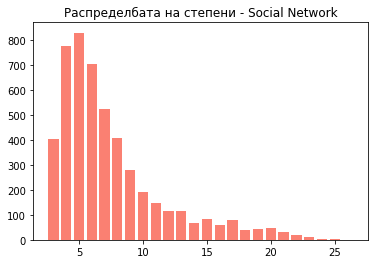

Name: Social Network
Type: Graph
Number of nodes: 5000
Number of edges: 18602
Average degree:   7.4408


In [30]:
network = nx.LFR_benchmark_graph(num_nodes, tau1, tau2, mu, average_degree, max_degree=max_degree, min_community=min_community, max_community=max_community, seed=42)
network.name = 'Social Network'
graph_info(network)
print(nx.info(network))

Mean на edge centrality: 0.00036033219330674007


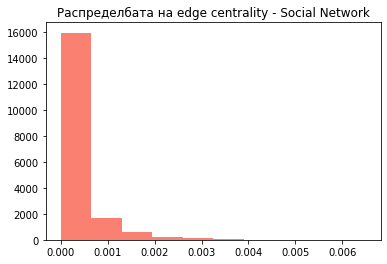

Отстранети се 5495 ребра
Name: Social Network 2
Type: Graph
Number of nodes: 5000
Number of edges: 13107
Average degree:   5.2428


In [26]:
valuable_edges,edgelist = getHighCentralityEdges(network)
network2=network.copy()
network2.name= "Social Network 2"
network2.remove_edges_from(valuable_edges)
print("Отстранети се " + str(len(valuable_edges)) + " ребра")
print(nx.info(network2))

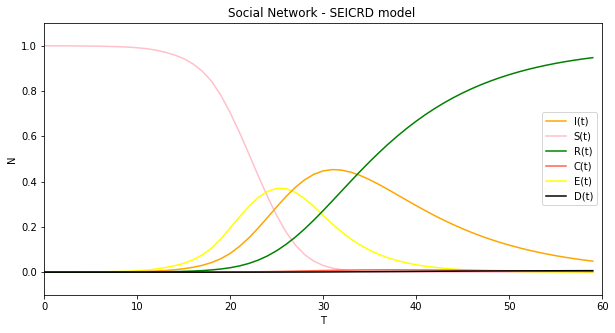

Број на инфицирани со beta= (3,2): 4999



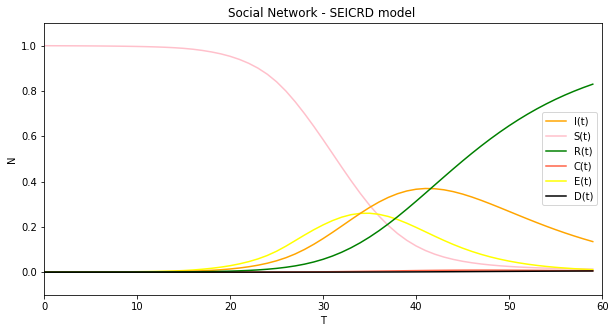

Број на инфицирани со beta= (2,5): 4933



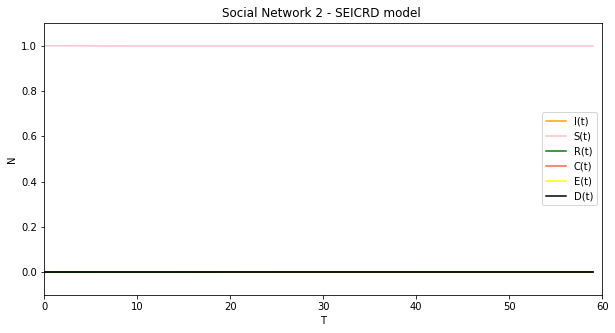

Број на инфицирани со помалце ребра: 7

Рестрикциите започнуваат t= 24


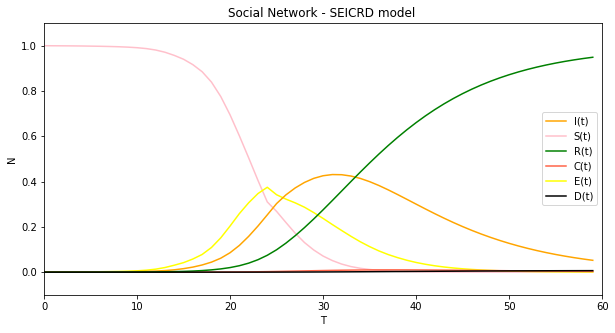

Број на инфицирани со рестрикции: 5000

Рестрикциите започнуваат t= 24


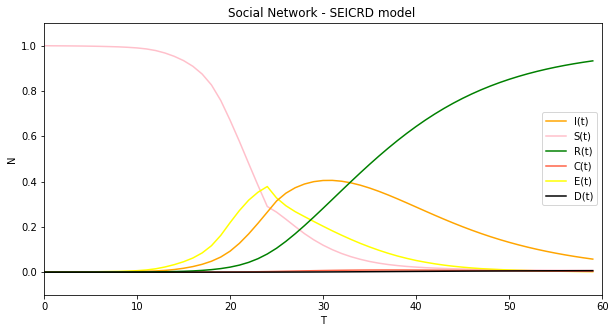

Број на инфицирани со social distancing: 4961



In [31]:
N,S,E,I,C,R,D  = model(network,(3,2),gamma,delta,prob1,prob2,itterations,50)
print("Број на инфицирани со beta= (3,2): "+str(N))
print()
N,S,E,I,C,R,D  = model(network,(2,5),gamma,delta,prob1,prob2,itterations,50)
print("Број на инфицирани со beta= (2,5): " +str(N))
print()
N,S,E,I,C,R,D  = model(network2,(3,2),gamma,delta,prob1,prob2,itterations,50)
print("Број на инфицирани со помалце ребра: " +str(N))
print()
N,S,E,I,C,R,D = model_restrictions(network,(3,2), (2,5) ,gamma,delta,prob1,prob2,itterations,50)
print("Број на инфицирани со рестрикции: " +str(N))
print()
N,S,E,I,C,R,D = model_sd_restrictions(network,(3,2), (2,5), gamma,delta,prob1,prob2,itterations,50)
print("Број на инфицирани со social distancing: " +str(N))
print()